In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

#Opis równania


W naszym projekcie będziemy używać równania do modelowania epidemiolgicznego SIS (susceptible–infected–susceptible - z ang. podatny-zarażony-podatny). Oznacza to, że każda jednostka jest podatna na zainfekowanie wiele razy w ciągu swojego życia. Samo równanie wygląda następująco. Niech $S_t$ oznacza liczbę podatnych, a $Y_t$ liczbę zarażonych w czasie $t$ oraz niech $N$ oznacza całkowitą liczbę populacji. Wiedząc, że $S_t+Y_t=N$ możemy rozważać stochastyczne równanie różniczkowe dla $Y_t$ przedstawione w następujący sposób
\begin{equation}
dY_t = Y_t(βN-μ-ν-βY_t)dt + σY_t(N-Y_t)dW_t
\end{equation}
gdzie: \\
$μ ≥ 0$ - wskaźnik śmiertelności na mieszkańca, \\
$ν ≥ 0$ - wskaźnik szybkości wyleczenia zakażonych osób \\
$β ≥ 0$ - współczynnik przenoszenia choroby \\
$W_t$ - ruch Browna \\
$σ$ - wariancja potencjalnie zakażonych kontaktów, jakie jeden osobnik nawiązuje z innymi osobnikami na małym przedziale czasowym $[t,t+dt)$.

Równanie to możemy zapisać w prostszej postaci:
\begin{equation}
dY_t=Y_t(a-bY_t)dt + σY_t(N-Y_t)dW_t, \quad 0≤t\le T
\end{equation}
gdzie \\
$a= βN-μ-ν$ \\
$b=β$ \\
Posłuży nam ona do prostszego zaimplementowania powyższego modelu, także będziemy podawać jej parametry dla $a$ oraz $b$.

In [ ]:
a=5
b=0.8
sigma=0.1
N=10
T=1

Zapiszmy funkcje naszego modelu

In [ ]:
def f(x):
  return x*(a-b*x)
def g(x):
  return sigma*x*(N-x)

In [ ]:
Interval=np.linspace(0,1,1000)

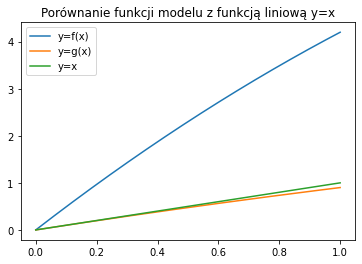

In [ ]:
plt.plot(Interval,np.abs(f(Interval)),label='y=f(x)')
plt.plot(Interval,np.abs(g(Interval)),label='y=g(x)')
plt.plot(Interval,Interval,label='y=x')
plt.title("Porównanie funkcji modelu z funkcją liniową y=x")
plt.legend()

#Generacja procesu Wienera

Generujemy ciąg $W_k$ oraz ciąg $\Delta W_k=W_{k+1}-W_k$ dyskretyzacji pewnej trajektorji procesu Wienera oraz ciąg $t_k$ z $\Delta t = t_{k+1} -t_k$ dla wszystkich k,  które będą używane w schematach przybliżających rozwiązanie naszego stochastycznego równania.

In [ ]:
def wiener(n):
  h = T/n
  t = np.linspace(0,T,n+1)
  dw = np.random.normal(0,np.sqrt(h),n)
  return t,dw

#Rozrzedzenie wygenerowanej dyskretyzacji

Ponieważ nie mamy rozwiązania dokładnego, rozwiązania przybliżone będziemy musieli porównywać do rozwiązania na zagęszczonej siatce. Tworzymy więc funkcję, która "rozrzedza" $10^k$ krotnie zadaną dyskretyzację procesu Wienera.

In [ ]:
def wiener_k(t,dw,k):
  n=int((len(t)-1)/10**k)
  tp = np.linspace(0,T,n+1)
  dW = np.zeros(n)
  for i in range(n):
    pom=0
    for j in range(10**k):
     pom=pom+dw[10**k*i+j]
    dW[i]=pom
  return tp, dW

#Schemat wygładzanego obcinania Lampertiego

Schemat wygładzanego obcinania Lampertiego (LST) wygląda następująco
\
     \begin{cases}
       x_{t_{i+1}} = x_{t_i}+f(x_{t_{i}})Δt+σNΔW_i, \\
       y_{t_i} = N \frac{e^{x_{t_i}}}{e^{x_{t_i}}+1},
     \end{cases}
\
gdzie punktami, które będziemy wykorzystywać w modelu są wartości wektora $y$. Funkcja $f(x)$ jest natomiast zadana w następujący sposób
\begin{equation}
  f(x) = a - (bN-a)e^x + σ^2N^2 \frac{e^x-1}{2(e^x+1)}
\end{equation}

Zaimplementujmy zatem naszą funkcję schematu:

In [ ]:
def f_s(x):
   return a-(b*N-a)*np.exp(x)+((sigma*N)**2)*(np.exp(x)-1)/(2*(np.exp(x)+1))

Następnie zaimplementujmy schemat wygładzanego obcinania Lampertiego do oblicznaia wartości $x_i$:

In [ ]:
def Lamperti(L,t,dw):
  n = len(dw)+1
  x = np.zeros(n)
  h = T/n
  x[0]=L
  for i in range(n-1):
    x[i+1]=x[i]+h*f_s(x[i])+sigma*N*dw[i]
  return t,x

oraz funkcję przeształcającą wartości $x_i$ na wektor $y$

In [ ]:
def y(x):
  return N*np.exp(x)/(np.exp(x)+1)

Wygenerujmy więc rozwiązanie dokładne na siatce $10^7$ oraz rozwiązania na rozrzedzonej siatce - rozrzedzimy ją $10^3$-krotnie, $10^4$-krotnie oraz $10^5$-krotnie

In [ ]:
%%time
tg1,wg1=wiener(10**7)
tp1,wp1=wiener_k(tg1,wg1,1)
tp2,wp2=wiener_k(tg1,wg1,2)
t11,w11=wiener_k(tg1,wg1,3)
t21,w21=wiener_k(tg1,wg1,4)
t31,w31=wiener_k(tg1,wg1,5)

Wall time: 22.9 s


Obliczamy wektor $x$ schematem Lampertiego

In [ ]:
%%time
tdL,x_tr=Lamperti(0.1,tg1,wg1)
tL4,x4_tr = Lamperti(0.1,tp1,wp1)
tL5,x5_tr = Lamperti(0.1,tp2,wp2)
tL1,x1_tr=Lamperti(0.1,t11,w11)
tL2,x2_tr=Lamperti(0.1,t21,w21)
tL3,x3_tr=Lamperti(0.1,t31,w31)

Wall time: 1min 17s


a następnie obliczmy wektor $y$

In [ ]:
xdL1=y(x_tr)
x4L1=y(x4_tr)
x5L1=y(x5_tr)
x1L1=y(x1_tr)
x2L1=y(x2_tr)
x3L1=y(x3_tr)

Zobaczmy jak nasze trajektorie przedstawiają się na wykresie

Wall time: 691 ms


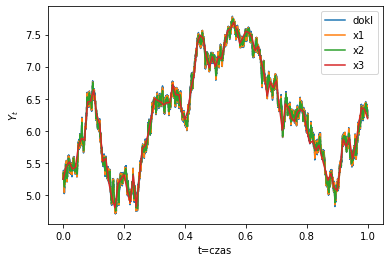

In [ ]:
%%time
plt.xlabel('t=czas')
plt.ylabel('$Y_t$')
plt.plot(tdL,xdL1, label='dokl')
plt.plot(tL1,x1L1, label='x1')
plt.plot(tL2,x2L1, label='x2')
plt.plot(tL3,x3L1, label='x3')
plt.legend()

Poniższa tabela przedstawia wartość w tym samym wybranym punkcie dla każdej z rozważanej siatek

In [ ]:
dane={'siatka':['dokł - 10^7','10^6','10^5','10^4','10^3','10^2'], 'wartość punktu':[xdL1[20*10**5],x4L1[20*10**4],x5L1[20*10**3],x1L1[20*10**2],x2L1[20*10],x3L1[20]]}
df=pd.DataFrame(dane)
df

,siatka,wartość punktu
0,dokł - 10^7,5.332588
1,10^6,5.332587
2,10^5,5.332574
3,10^4,5.332519
4,10^3,5.332475
5,10^2,5.316745


Zobaczmy jak prezentują się logarytmy błędów rozważanych siatek na wykresie

In [ ]:
blad=np.zeros(5)
blad[0]=np.abs(xdL1[-1]-x4L1[-1])
blad[1]=np.abs(xdL1[-1]-x5L1[-1])
blad[2]=np.abs(xdL1[-1]-x1L1[-1])
blad[3]=np.abs(xdL1[-1]-x2L1[-1])
blad[4]=np.abs(xdL1[-1]-x3L1[-1])
blad_log=np.log(blad)
blad

array([1.40015733e-06, 2.59857529e-06, 1.49121398e-04, 1.95442404e-04,
       1.82656684e-02])

In [ ]:
bledy={'siatka':['10^6','10^5','10^4','10^3','10^2'], 'blad':[blad[0],blad[1],blad[2],blad[3],blad[4]]}
bd=pd.DataFrame(bledy)
bd

,siatka,blad
0,10^6,0.000001
1,10^5,0.000003
2,10^4,0.000149
3,10^3,0.000195
4,10^2,0.018266


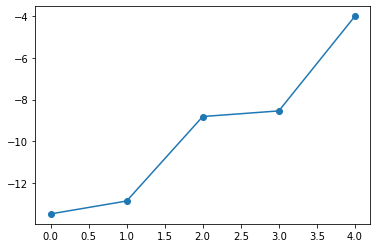

In [ ]:
plt.plot([0,1,2,3,4],blad_log)
plt.scatter([0,1,2,3,4],blad_log)

Po otrzymaniu powyższej zależości, chcemy spróbować w pewnym stopniu losowosć stworzoną przez wykorzystanie zaledwie jednej trajektorji procesu Wienera. Powtórzmy więc eksperyment 20 razy i obliczmy średnią wyników, które przybliży nam wartość oczekiwaną wyników.

In [ ]:
%%time
powt=50
bladLamperti1=np.zeros(powt)
bladLamperti2=np.zeros(powt)
bladLamperti3=np.zeros(powt)
bladLamperti4=np.zeros(powt)
bladLamperti5=np.zeros(powt)
for i in range(powt):
  tg,wg=wiener(10**7)
  t4,w4=wiener_k(tg,wg,1)
  t5,w5=wiener_k(tg,wg,2)
  t1,w1=wiener_k(tg,wg,3)
  t2,w2=wiener_k(tg,wg,4)
  t3,w3=wiener_k(tg,wg,5)
  td,x_tr=Lamperti(0.1,tg,wg)
  tE1,x1_tr=Lamperti(0.1,t1,w1)
  tE2,x2_tr=Lamperti(0.1,t2,w2)
  tE3,x3_tr=Lamperti(0.1,t3,w3)
  tE4,x4_tr=Lamperti(0.1,t4,w4)
  tE5,x5_tr=Lamperti(0.1,t5,w5)
  xdL=y(x_tr)
  x1L=y(x1_tr)
  x2L=y(x2_tr)
  x3L=y(x3_tr)
  x4L=y(x4_tr)
  x5L=y(x5_tr)
  bladLamperti1[i]=np.abs(xdL[-1]-x1L[-1])
  bladLamperti2[i]=np.abs(xdL[-1]-x2L[-1])
  bladLamperti3[i]=np.abs(xdL[-1]-x3L[-1])
  bladLamperti4[i]=np.abs(xdL[-1]-x4L[-1])
  bladLamperti5[i]=np.abs(xdL[-1]-x5L[-1])
blad1=np.mean(bladLamperti1)
blad2=np.mean(bladLamperti2)
blad3=np.mean(bladLamperti3)
blad4=np.mean(bladLamperti4)
blad5=np.mean(bladLamperti5)

CPU times: user 36min 7s, sys: 6.86 s, total: 36min 14s
Wall time: 36min 29s


Otrzymane średnie błędy wyglądają następująco

In [ ]:
blad_LST=np.zeros(5)
blad_LST[0]=blad4
blad_LST[1]=blad5
blad_LST[2]=blad1
blad_LST[3]=blad2
blad_LST[4]=blad3
blad_LST

array([1.42624471e-06, 1.39067507e-05, 1.42149885e-04, 1.70389675e-03,
       1.38506895e-02])

In [ ]:
nowe_bledy={'siatka':['10^6','10^5','10^4','10^3','10^2'], 'blad':[blad_LST[0],blad_LST[1],blad_LST[2],blad_LST[3],blad_LST[4]]}
nw_bd=pd.DataFrame(nowe_bledy)
nw_bd

,siatka,blad
0,10^6,0.000001
1,10^5,0.000014
2,10^4,0.000142
3,10^3,0.001704
4,10^2,0.013851


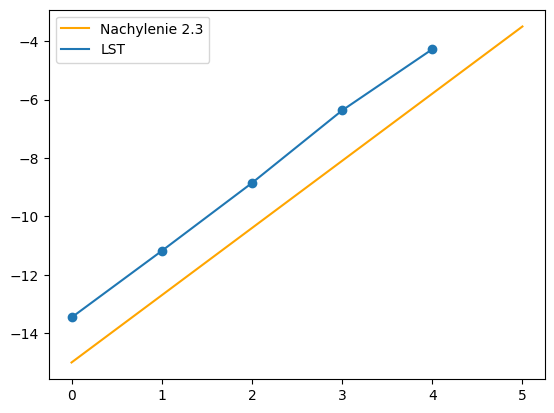

In [ ]:
x = np.linspace(0, 5, 1000)
plt.plot(x,2.3*x-15,color='orange', label="Nachylenie 2.3")
plt.plot([0,1,2,3,4],np.log(blad_LST), label="LST")
plt.scatter([0,1,2,3,4],np.log(blad_LST))
plt.legend()

Widzimy więc, że po kilku iteracjach nasze tempo zbieżności ustabilizowało się. Wynosi ono około 3.

#Schemat Eulera-Maruyamy

Schematem Eulera Maruyamy nazywamy następujący ciąg przybliżeń: \\
$Y_{i+1}(t)=Y_i(t)+a(Y_i(t))\Delta t+b(Y_i(t))\Delta W_i$ \\
Sprawdźmy zatem jakie wyniki uzyskamy za pomocą schematu Eulera

In [ ]:
def Euler(E,t,dw):
  n = len(dw)+1
  y = np.zeros(n)
  h = T/n
  y[0]=E
  for i in range(n-1):
    y[i+1]=y[i]+f(y[i])*h+g(y[i])*dw[i]
  return t,y

In [ ]:
pp=y(0.1)

In [ ]:
%%time
tdE,xdE=Euler(pp,tg1,wg1)
tE4,x4E=Euler(pp,tp1,wp1)
tE5,x5E=Euler(pp,tp2,wp2)
tE1,x1E=Euler(pp,t11,w11)
tE2,x2E=Euler(pp,t21,w21)
tE3,x3E=Euler(pp,t31,w31)

CPU times: user 23.1 s, sys: 108 ms, total: 23.2 s
Wall time: 23.4 s


CPU times: user 366 ms, sys: 381 ms, total: 747 ms
Wall time: 748 ms


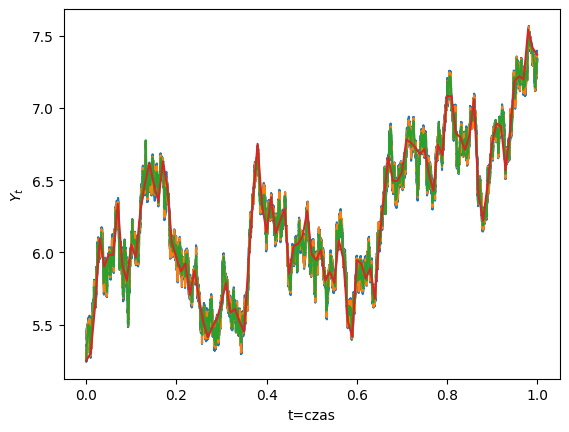

In [ ]:
%%time
plt.xlabel('t=czas')
plt.ylabel('$Y_t$')
plt.plot(tdE,xdE)
plt.plot(tE1,x1E)
plt.plot(tE2,x2E)
plt.plot(tE3,x3E)

Trajektoria ta wygląda znacznie inaczej niż ta uzyskana przy pomocy schematu wygładzanego obcinania Lampertiego. Zobaczmy zatem jak obie trajektorie prezentują się na jednym wykresie.

CPU times: user 622 ms, sys: 525 ms, total: 1.15 s
Wall time: 1.15 s


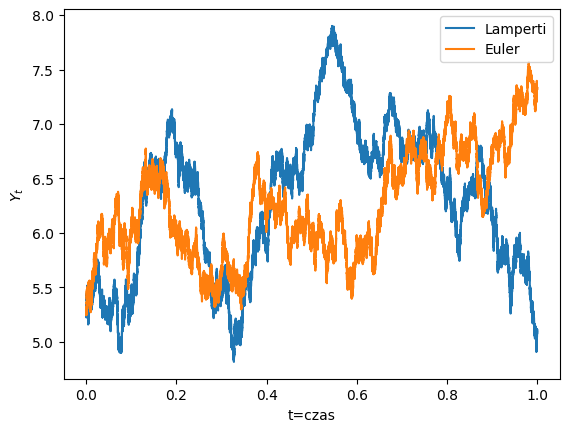

In [ ]:
%%time
plt.xlabel('t=czas')
plt.ylabel('$Y_t$')
plt.plot(tdL,xdL1, label='Lamperti')
plt.plot(tdE,xdE, label='Euler')
plt.legend()

Jak widzimy różnica pomiędzy otrzymanymi trajektoriami jest bardzo duża. Wynika to z faktu, że w naszym modelu SIS mamy do rozwiązania funkcję, która jest mocno nieliniowa o eksponentalnym wzroście, a schemat Eulera-Maruyamy jest przeznaczony dla funkcji, które są co najwyżej liniowego wzrostu.

Z tego też powodu porówanjmy nasz schemat wygładzanego obcinania Lampertiego z niejawnym schematem Lampertiego wstecznego (Lamperti-bakward Euler - LBE):
\
     \begin{cases}
       x_{t_{i+1}} = x_{t_i}+f(x_{t_{i+1}})Δt+σNΔW_i, \\
       y_{t_i} = N \frac{e^{x_{t_i}}}{e^{x_{t_i}}+1},
     \end{cases}


In [ ]:
def Lamperti_Backward(L,t,dw):
  n = len(dw)+1
  x = np.zeros(n)
  h = T/n
  x[0]=L
  for i in range(n-1):
    xnowe=x[i]+h*f_s(x[i])+sigma*N*dw[i]
    xnowe=x[i]+h*f_s(xnowe)+sigma*N*dw[i]
    xnowe=x[i]+h*f_s(xnowe)+sigma*N*dw[i]
    xnowe=x[i]+h*f_s(xnowe)+sigma*N*dw[i]
    x[i+1]=x[i]+h*f_s(xnowe)+sigma*N*dw[i]
  return t,x

In [ ]:
%%time
tdB,xdB_tr=Lamperti_Backward(0.1,tg1,wg1)
tB4,x4B_tr=Lamperti_Backward(0.1,tp1,wp1)
tB5,x5B_tr=Lamperti_Backward(0.1,tp2,wp2)
tB1,x1B_tr=Lamperti_Backward(0.1,t11,w11)
tB2,x2B_tr=Lamperti_Backward(0.1,t21,w21)
tB3,x3B_tr=Lamperti_Backward(0.1,t31,w31)

Wall time: 5min 3s


In [ ]:
xdB1=y(xdB_tr)
x1B1=y(x1B_tr)
x2B1=y(x2B_tr)
x3B1=y(x3B_tr)
x4B1=y(x4B_tr)
x5B1=y(x5B_tr)

Wall time: 428 ms


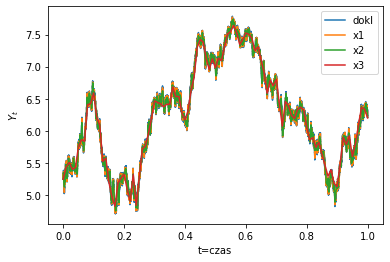

In [ ]:
%%time
plt.xlabel('t=czas')
plt.ylabel('$Y_t$')
plt.plot(tdB,xdB1, label='dokl')
plt.plot(tB1,x1B1, label='x1')
plt.plot(tB2,x2B1, label='x2')
plt.plot(tB3,x3B1, label='x3')
plt.legend()

Porównując schemat LST wraz z schematem LBE możemy zobaczyć, że ich trajektorie pokrywają się ze sobą

In [ ]:
# %%time
# plt.xlabel('t=czas')
# plt.ylabel('$Y_t$')
# plt.plot(tdB,xdB1, label='Lamperti Backward')
# plt.plot(tdL,xdL1, label='Lamperti')
# plt.legend()

Standardowo zobaczymy jak wyglądają wartości dla losowych punktów w zależności od gęstości siatki oraz błędy dla poszczególnych rozrzedzonych siatek.

In [ ]:
dane2={'siatka':['dokł - 10^7','10^6','10^5','10^4','10^3','10^2'], 'wartość punktu':[xdB1[20*10**5],x4B1[20*10**4],x4B1[20*10**3],x1B1[20*10**2],x2B1[20*10],x3B1[20]]}
df2=pd.DataFrame(dane2)
df2

,siatka,wartość punktu
0,dokł - 10^7,5.332589
1,10^6,5.332587
2,10^5,5.516404
3,10^4,5.332592
4,10^3,5.333202
5,10^2,5.324466


In [ ]:
blad_B=np.zeros(5)
blad_B[0]=np.abs(xdB1[-1]-x4B1[-1])
blad_B[1]=np.abs(xdB1[-1]-x5B1[-1])
blad_B[2]=np.abs(xdB1[-1]-x1B1[-1])
blad_B[3]=np.abs(xdB1[-1]-x2B1[-1])
blad_B[4]=np.abs(xdB1[-1]-x3B1[-1])
blad_B_log=np.log(blad_B)

In [ ]:
bledy2={'siatka':['10^6','10^5','10^4','10^3','10^2'], 'blad':[blad_B[0],blad_B[1],blad_B[2],blad_B[3],blad_B[4]]}
bd2=pd.DataFrame(bledy2)
bd2

,siatka,blad
0,10^6,0.000002
1,10^5,0.000011
2,10^4,0.000061
3,10^3,0.000689
4,10^2,0.008359


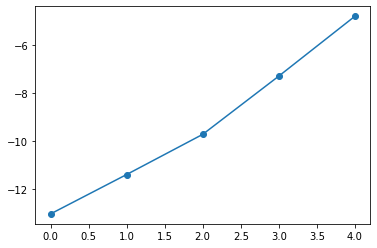

In [ ]:
plt.plot([0,1,2,3,4],blad_B_log)
plt.scatter([0,1,2,3,4],blad_B_log)

Analogicznie jak powyżej, przeprowadźmy 20 przejść i na ich podstawie wyliczmy uśredniony błąd dla danego scheamtu.

In [ ]:
%%time
powt=80
bladLBE1=np.zeros(powt)
bladLBE2=np.zeros(powt)
bladLBE3=np.zeros(powt)
bladLBE4=np.zeros(powt)
bladLBE5=np.zeros(powt)
for i in range(powt):
  tg,wg=wiener(10**7)
  t4,w4=wiener_k(tg,wg,1)
  t5,w5=wiener_k(tg,wg,2)
  t1,w1=wiener_k(tg,wg,3)
  t2,w2=wiener_k(tg,wg,4)
  t3,w3=wiener_k(tg,wg,5)
  td,xdB_tr=Lamperti_Backward(0.1,tg,wg)
  tB1,x1B_tr=Lamperti_Backward(0.1,t1,w1)
  tB2,x2B_tr=Lamperti_Backward(0.1,t2,w2)
  tB3,x3B_tr=Lamperti_Backward(0.1,t3,w3)
  tB4,x4B_tr=Lamperti_Backward(0.1,t4,w4)
  tB5,x5B_tr=Lamperti_Backward(0.1,t5,w5)
  xdB=y(xdB_tr)
  x1B=y(x1B_tr)
  x2B=y(x2B_tr)
  x3B=y(x3B_tr)
  x4B=y(x4B_tr)
  x5B=y(x5B_tr)
  bladLBE1[i]=np.abs(xdB[-1]-x1B[-1])
  bladLBE2[i]=np.abs(xdB[-1]-x2B[-1])
  bladLBE3[i]=np.abs(xdB[-1]-x3B[-1])
  bladLBE4[i]=np.abs(xdB[-1]-x4B[-1])
  bladLBE5[i]=np.abs(xdB[-1]-x5B[-1])
blad1=np.mean(bladLBE1)
blad2=np.mean(bladLBE2)
blad3=np.mean(bladLBE3)
blad4=np.mean(bladLBE4)
blad5=np.mean(bladLBE5)

Wall time: 7h 44min 58s


In [ ]:
blad_LBE=np.zeros(5)
blad_LBE[0]=blad4
blad_LBE[1]=blad5
blad_LBE[2]=blad1
blad_LBE[3]=blad2
blad_LBE[4]=blad3
blad_LBE

array([1.23506328e-06, 1.47349260e-05, 1.61980185e-04, 1.34165609e-03,
       1.47455025e-02])

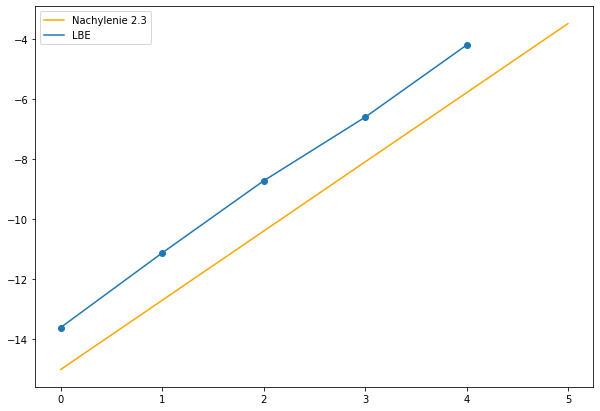

In [ ]:
x = np.linspace(0, 5, 1000)
plt.figure(figsize=(10,7))
plt.plot(x,2.3*x-15,color='orange', label="Nachylenie 2.3")
plt.plot([0,1,2,3,4],np.log(blad_LBE), label="LBE")
plt.scatter([0,1,2,3,4],np.log(blad_LBE))
plt.legend()

In [ ]:
# porownanie={'siatka':['10^6','10^5','10^4','10^3','10^2'], 'LST':[blad_LST[0],blad_LST[1],blad_LST[2],blad_LST[3],blad_LST[4]], 'LBE':[blad_LBE[0],blad_LBE[1],blad_LBE[2],blad_LBE[3],blad_LBE[4]]}
# por=pd.DataFrame(porownanie)
# por

Widzimy zatem, że schemat LBE daje nam nieco dokładniejsze wyniki niż schemat wygładzanego obcinania Lampertiego, lecz długość jego wykonywania jest znacznie większa (około 4-krotnie). Wynika to z faktu, że LST jest schematem jawnym, natomiast LBE niejawnym.